In [87]:
import numpy as np
import pandas as pd
import pyhere
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [88]:
dir_data_raw = pyhere.here().resolve().joinpath("data", "raw")
dir_data_interim = pyhere.here().resolve().joinpath("data", "interim")


In [89]:
columns = ['capacity_mw', 'latitude', 'longitude', 'primary_fuel', 'commissioning_year', 'year_of_capacity_data', 'other_fuel1', 'other_fuel2', 'other_fuel3', 'generation_gwh_2013',
           'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017', 'generation_gwh_2018', 'generation_gwh_2019', 'generation_data_source']
df_power_plants = pd.read_csv(dir_data_raw/"global_power_plant_database.csv", usecols=columns, engine='python')

In [90]:
df_power_plants.head()

,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,other_fuel3,commissioning_year,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018,generation_gwh_2019,generation_data_source
0,33.0,32.322,65.1190,Hydro,NaN,NaN,NaN,NaN,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.0,31.670,65.7950,Solar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.0,31.623,65.7920,Solar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,66.0,34.556,69.4787,Hydro,NaN,NaN,NaN,NaN,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100.0,34.641,69.7170,Hydro,NaN,NaN,NaN,NaN,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
df_power_plants.dtypes

capacity_mw               float64
latitude                  float64
longitude                 float64
primary_fuel               object
other_fuel1                object
other_fuel2                object
other_fuel3                object
commissioning_year        float64
year_of_capacity_data     float64
generation_gwh_2013       float64
generation_gwh_2014       float64
generation_gwh_2015       float64
generation_gwh_2016       float64
generation_gwh_2017       float64
generation_gwh_2018       float64
generation_gwh_2019       float64
generation_data_source     object
dtype: object

In [92]:
# df_power_plants.astype({
#     'capacity_mw': 'float', 
#     'latitude': 'decimal', 
#     'longitude': 'decimal', 
#     'commissioning_year': 'int', 
#     'generation_gwh_2013': 'float', 
#     'generation_gwh_2014': 'float', 
#     'generation_gwh_2015': 'float', 
#     'generation_gwh_2016': 'float', 
#     'generation_gwh_2017': 'float', 
#     'generation_gwh_2018': 'float', 
#     'generation_gwh_2019': 'float'}).dtypes

In [93]:
df_power_plants[['generation_gwh_2014']].value_counts().sort_index(ascending=False)

generation_gwh_2014
 32320.917             1
 28127.000             1
 27594.000             1
 26738.300             1
 24501.000             1
                      ..
-472.543               1
-491.183               1
-493.746               1
-700.889               1
-989.619               1
Length: 6159, dtype: int64

In [94]:
df_power_plants.describe(include='all')

,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,other_fuel3,commissioning_year,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018,generation_gwh_2019,generation_data_source
count,34936.000000,34936.000000,34936.000000,34936,1944,276,92,17447.000000,14887.000000,6417.000000,7226.000000,8203.000000,9144.000000,9500.000000,9637.000000,9659.000000,11400
unique,NaN,NaN,NaN,15,12,11,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
top,NaN,NaN,NaN,Solar,Oil,Gas,Gas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U.S. Energy Information Administration
freq,NaN,NaN,NaN,10665,1169,100,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9715
mean,163.355148,32.816637,-6.972803,NaN,NaN,NaN,NaN,1997.414823,2018.218849,592.696107,656.863891,762.368840,693.149763,661.834161,517.320785,423.922436,NaN
std,489.636072,22.638603,78.405850,NaN,NaN,NaN,NaN,23.397835,1.606428,2174.833482,2231.464288,2533.459828,2404.516759,2369.296957,1975.302686,1698.506485,NaN
min,1.000000,-77.847000,-179.977700,NaN,NaN,NaN,NaN,1896.000000,2000.000000,-947.600000,-989.619000,-864.428000,-768.620000,-934.944000,-982.622000,-780.339000,NaN
25%,4.900000,29.256475,-77.641550,NaN,NaN,NaN,NaN,1988.000000,2017.000000,1.947000,2.260000,2.664500,2.729000,2.467000,2.242000,2.751500,NaN
50%,16.745000,39.727750,-2.127100,NaN,NaN,NaN,NaN,2007.000000,2019.000000,23.426000,23.608500,26.142000,22.462389,17.876500,12.530000,11.530000,NaN
75%,75.344250,46.263125,49.502675,NaN,NaN,NaN,NaN,2014.000000,2019.000000,199.706000,226.322250,285.862583,249.866750,214.505150,151.117000,122.781498,NaN


In [95]:
# df_power_plants['generation_gwh_2013'].notna()
df_power_plants_with_generation_not_nan = df_power_plants.loc[df_power_plants['generation_gwh_2013'].notna() & df_power_plants['generation_gwh_2014'].notna() & df_power_plants['generation_gwh_2015'].notna() & df_power_plants['generation_gwh_2016'].notna() & df_power_plants['generation_gwh_2017'].notna() & df_power_plants['generation_gwh_2018'].notna() & df_power_plants['generation_gwh_2019'].notna()]
df_power_plants_with_generation_not_nan.reset_index(drop = True, inplace=True)

In [96]:
df_power_plants_with_generation_not_nan.describe(include='all')

,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,other_fuel3,commissioning_year,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018,generation_gwh_2019,generation_data_source
count,6030.000000,6030.000000,6030.000000,6030,1289,251,85,6030.000000,6030.0,6030.000000,6030.000000,6030.000000,6030.000000,6030.000000,6030.000000,6030.000000,6030
unique,NaN,NaN,NaN,14,12,11,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
top,NaN,NaN,NaN,Gas,Oil,Gas,Gas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U.S. Energy Information Administration
freq,NaN,NaN,NaN,1520,725,93,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6030
mean,176.826036,39.452107,-96.103823,NaN,NaN,NaN,NaN,1988.051581,2019.0,574.700244,569.378246,580.336826,558.922911,549.531135,553.123646,608.501120,NaN
std,421.269219,5.847690,18.900556,NaN,NaN,NaN,NaN,25.367746,0.0,2073.165791,2078.617195,2059.131265,2032.836733,2032.297872,2029.659913,2080.432481,NaN
min,1.000000,18.974200,-171.712400,NaN,NaN,NaN,NaN,1896.000000,2019.0,-947.600000,-989.619000,-864.428000,-768.620000,-934.944000,-982.622000,-780.339000,NaN
25%,4.100000,35.363375,-112.755500,NaN,NaN,NaN,NaN,1975.935708,2019.0,1.837250,2.288500,2.170000,2.154000,1.860000,1.796000,3.529250,NaN
50%,20.000000,39.961650,-92.784450,NaN,NaN,NaN,NaN,1995.000000,2019.0,22.114500,22.058000,21.683000,20.683000,20.587000,20.577000,28.879000,NaN
75%,111.425000,42.908550,-80.937950,NaN,NaN,NaN,NaN,2008.000000,2019.0,188.656004,180.372750,185.308500,182.518500,175.037000,184.516750,236.261500,NaN


<AxesSubplot:xlabel='primary_fuel'>

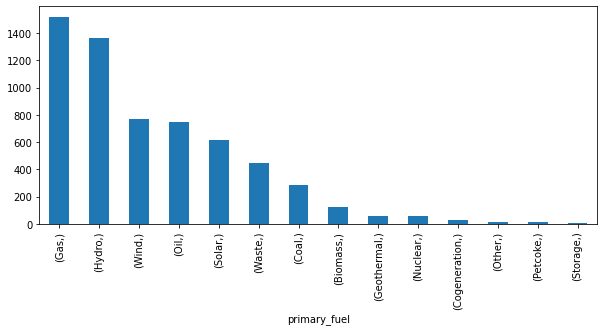

In [97]:
plt.figure(figsize=(10,4))
df_power_plants_with_generation_not_nan[['primary_fuel']].value_counts().plot.bar()

In [98]:
df_power_plants_with_generation_not_nan['primary_fuel'].unique()

array(['Solar', 'Gas', 'Oil', 'Wind', 'Hydro', 'Coal', 'Biomass', 'Waste',
       'Cogeneration', 'Geothermal', 'Petcoke', 'Nuclear', 'Other',
       'Storage'], dtype=object)

In [99]:
solar_wind_or_not = {'not_solar_or_wind':[
                                        'Gas', 
                                        'Oil', 
                                        'Hydro', 
                                        'Coal', 
                                        'Biomass', 
                                        'Waste',
                                        'Cogeneration', 
                                        'Geothermal', 
                                        'Petcoke', 
                                        'Nuclear', 
                                        'Other',
                                        'Storage'
                                        ],
                        'solar_or_wind':[
                                        'Solar',
                                        'Wind']}
solar_wind_or_not

{'not_solar_or_wind': ['Gas',
  'Oil',
  'Hydro',
  'Coal',
  'Biomass',
  'Waste',
  'Cogeneration',
  'Geothermal',
  'Petcoke',
  'Nuclear',
  'Other',
  'Storage'],
 'solar_or_wind': ['Solar', 'Wind']}

In [100]:
# df_power_plants_with_generation_not_nan['solar_wind_or_not'] = 

# df_power_plants_with_generation_not_nan['solar_wind_or_not'] = df_power_plants_with_generation_not_nan['primary_fuel'] == ('Wind' or 'Solar') ? 'solar_wind' : 'not'

df_power_plants_with_generation_not_nan['solar_wind_or_not'] = np.where((df_power_plants_with_generation_not_nan[['primary_fuel']] == 'Wind') | (df_power_plants_with_generation_not_nan[['primary_fuel']] == 'Solar'), 'solar_wind','not')

/tmp/ipykernel_865/3521904982.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_power_plants_with_generation_not_nan['solar_wind_or_not'] = np.where((df_power_plants_with_generation_not_nan[['primary_fuel']] == 'Wind') | (df_power_plants_with_generation_not_nan[['primary_fuel']] == 'Solar'), 'solar_wind','not')


In [101]:
df_power_plants_with_generation_not_nan[['primary_fuel', 'solar_wind_or_not']].sample(20)

,primary_fuel,solar_wind_or_not
2890,Hydro,not
5753,Hydro,not
5293,Hydro,not
5411,Hydro,not
1969,Gas,not
5253,Oil,not
4527,Hydro,not
4030,Solar,solar_wind
5878,Coal,not
4790,Gas,not


<AxesSubplot:xlabel='solar_wind_or_not'>

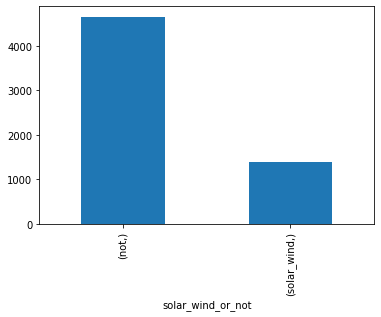

In [102]:
# df_power_plants_with_generation_not_nan.groupby(['solar_wind_or_not', 'primary_fuel'])['primary_fuel'].count().plot.bar()
df_power_plants_with_generation_not_nan[['solar_wind_or_not']].value_counts().plot.bar()

In [103]:
df_power_plants_with_generation_not_nan.to_csv(dir_data_interim/"power_plants_with_generation_not_nan.csv")